# 이미지 데이터 파이토치 커스터마이징하기

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
import torch
import torchvision
from torchvision import transforms # 이미지 데이터 transform
from torch.utils.data import DataLoader # 이미지 데이터 로더
import os
import glob

In [3]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'

torch.manual_seed(777)
if device == 'cuda':
  torch.cuda.manual_seed_all(777)

In [4]:
# 경로 지정

train_path = '/content/drive/MyDrive/DCD/Project/train'
test_path = '/content/drive/MyDrive/DCD/Project/test'

flood_dir = '/flood/'
not_flood_dir = '/not_flood/'

# 이미지 데이터 전처리   
> 파이토치 라이브러리를 이용한 쉬운 방법 or albumentation 라이브러리를 이용한 데이터 커스터마이징 2가지 방식으로 진행합니다.

 1. 이미지를 resize합니다.   
    
 2. resize한 이미지에 대해서 스케일링을 준비합니다.   
    
 3. 전처리한 이미지들을 augmentation해줍니다.   
   
 4. augmentation transform을 진행했으면, data loader로 학습을 준비합니다.

## 파이토치 라이브러리를 이용해 쉽게 진행
1. 이미지 resize & 스케일링
> 꼭 resize를 진행한 이미지들을 스케일링 해줍니다.   

In [5]:
resize_trans = transforms.Compose([
                                   transforms.Resize((128,128)),
                                   transforms.ToTensor()
])

resize_train = torchvision.datasets.ImageFolder(root=train_path, transform=resize_trans)
resize_test = torchvision.datasets.ImageFolder(root=test_path, transform=resize_trans)

In [6]:
resize_train[0][0].shape # ToTensor를 진행했기 때문에 데이터가 torch(C,H,W) 형태로 바뀜

torch.Size([3, 128, 128])

In [7]:
resize_train[0][0]

tensor([[[0.1882, 0.1804, 0.1882,  ..., 0.2824, 0.3373, 0.3412],
         [0.1608, 0.1686, 0.1647,  ..., 0.2510, 0.3333, 0.3216],
         [0.0863, 0.1137, 0.1490,  ..., 0.2784, 0.3451, 0.3294],
         ...,
         [0.1412, 0.1294, 0.1373,  ..., 0.8157, 0.7686, 0.8078],
         [0.1412, 0.1294, 0.1373,  ..., 0.7922, 0.7725, 0.7922],
         [0.1412, 0.1294, 0.1373,  ..., 0.6706, 0.6353, 0.6824]],

        [[0.1922, 0.1843, 0.1922,  ..., 0.2392, 0.3020, 0.3176],
         [0.1647, 0.1725, 0.1686,  ..., 0.2157, 0.3020, 0.2980],
         [0.0863, 0.1137, 0.1490,  ..., 0.2510, 0.3216, 0.3098],
         ...,
         [0.1412, 0.1294, 0.1373,  ..., 0.7294, 0.6902, 0.7569],
         [0.1412, 0.1294, 0.1373,  ..., 0.7059, 0.6902, 0.7412],
         [0.1412, 0.1294, 0.1373,  ..., 0.5882, 0.5569, 0.6314]],

        [[0.1333, 0.1255, 0.1333,  ..., 0.1529, 0.2118, 0.2235],
         [0.1098, 0.1176, 0.1137,  ..., 0.1255, 0.2078, 0.2039],
         [0.0431, 0.0706, 0.1020,  ..., 0.1569, 0.2235, 0.

In [8]:
import numpy as np
np.mean(resize_train[0][0].numpy(),axis=(1,2)) # numpy로 바꾸고, axis = 1,2 mean으로 RGB mean/std 뽑기

array([0.40623063, 0.3981314 , 0.35791737], dtype=float32)

In [9]:
def get_mean_std(dataset):
  meanRGB = [np.mean(image.numpy(), axis=(1,2)) for image,_ in dataset]
  stdRGB = [np.std(image.numpy(), axis=(1,2)) for image,_ in dataset]

  meanR = np.mean([m[0] for m in meanRGB])
  meanG = np.mean([m[1] for m in meanRGB])
  meanB = np.mean([m[2] for m in meanRGB])

  stdR = np.mean([s[0] for s in stdRGB])
  stdG = np.mean([s[1] for s in stdRGB])
  stdB = np.mean([s[2] for s in stdRGB])

  print(meanR, meanG, meanB)
  print(stdR, stdG, stdB)

In [10]:
get_mean_std(resize_train)

0.47416756 0.46725333 0.44245443
0.21332812 0.20913981 0.22899082


In [11]:
get_mean_std(resize_test)

0.48069975 0.47862804 0.45408225
0.2101699 0.20632344 0.22959438


In [12]:
# normalization 준비

resize_train_mean=[0.47416756, 0.46725333, 0.44245443]
resize_train_std=[0.21332812, 0.20913981, 0.22899082]

resize_test_mean=[0.48069975, 0.47862804, 0.45408225]
resize_test_std=[0.2101699, 0.20632344, 0.22959438]

3. transform을 이용해 data augmentation하기

In [13]:
transform_train = transforms.Compose([
    transforms.Resize((128, 128)), # 이미지 resize
    transforms.RandomCrop(124), # 이미지를 랜덤으로 크롭
    transforms.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2, hue=0.2), # 이미지 지터링(밝기, 대조, 채비, 색조)
    transforms.RandomHorizontalFlip(p = 1), # p확률로 이미지 좌우반전
    transforms.RandomVerticalFlip(p = 1), # p확률로 상하반전
    transforms.ToTensor(),
    transforms.Normalize(resize_train_mean, resize_train_std)
])

transform_test = transforms.Compose([
    transforms.Resize((128, 128)), 
    transforms.ToTensor(),
    transforms.Normalize(resize_test_mean, resize_test_std)
])

trainset = torchvision.datasets.ImageFolder(root=train_path, transform=transform_train)
testset = torchvision.datasets.ImageFolder(root=test_path, transform=transform_test)

train_loader = torch.utils.data.DataLoader(trainset, batch_size=1,
                                          shuffle=True, num_workers=0)

test_loader = torch.utils.data.DataLoader(testset, batch_size=1,
                                         shuffle=False, num_workers=0)


In [14]:
dataiter = iter(train_loader)
images, labels = dataiter.next()
images.shape

torch.Size([1, 3, 124, 124])

augmentation을 적용한 침수 이미지 확인하기

In [15]:
import matplotlib.pyplot as plt
import numpy as np

%matplotlib inline

def imshow(img, mean, std):
    npimg = img.numpy()
    img = np.transpose( npimg, (1, 2, 0) )
    img = img * std + mean # renormalize
    img = img.clip(0, 1)
    plt.imshow(img)
    plt.show()


none_trans = torchvision.datasets.ImageFolder(root=train_path, transform=None)

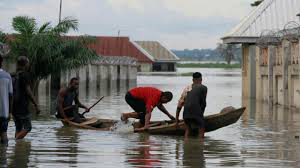

In [16]:
# 원본 이미지
none_trans[359][0]

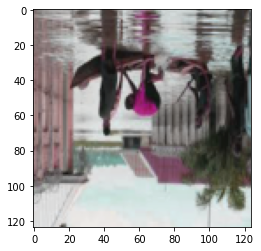

In [17]:
# augmentation을 적용한 flood 이미지
imshow((trainset[359][0]),resize_train_mean,resize_train_std)

data loader까지 정의했으니 이제 학습을 위한 데이터 준비는 끝났습니다!

## albumentation을 라이브러리를 이용한 이미지 데이터 커스터마이징
> albumentation으로 데이터를 커스터마이징하면 훨씬 자유도가 높고 속도가 빠르지만, pytorch data pipeine까지 직접 커스텀해야함.   

1. data pipeline 만들기

In [33]:
# 경로 지정

train_path = '/content/drive/MyDrive/DCD/Project/train'
test_path = '/content/drive/MyDrive/DCD/Project/test'

Dataset_path = '/content/drive/MyDrive/DCD/Project'

flood_dir = '/flood/'
not_flood_dir = '/not_flood/'

In [34]:
from torch.utils.data import Dataset, DataLoader # 데이터 커스터마이징
from PIL import Image # PIL = Python Image Library
import cv2 # albumentation transform을 쓰려면 꼭 이 라이브러리를 이용
import tensorflow as tf

class inhovation_Dataset(Dataset):

  def __init__(self, file_path, mode, transform=None):
    self.all_data = sorted(glob.glob(os.path.join(file_path, mode, '*', '*')))
    self.transform = transform

  def __getitem__(self, index):

    if torch.is_tensor(index):        # 인덱스가 tensor 형태일 수 있으니 리스트 형태로 바꿔준다.
       index = index.tolist()

    data_path = self.all_data[index]
    #img = np.array(Image.open(data_path).convert("RGB")) # albumenatation transform을 쓰려면 cv2 라이브러리로 이미지를 읽어야 함
    image=cv2.imread(data_path)
    image=cv2.cvtColor(image, cv2.COLOR_BGR2RGB) # BGR -> RGB 변환

    # transform 적용
    if self.transform is not None:    
       augmented = self.transform(image=image)
       image = augmented['image'] 

    # 이미지 이름을 활용해 label 부여
    label=[]                                
    if os.path.basename(data_path).startswith("flood") == True:
        label = 0
    else :
        label = 1
    return image, label

  def __len__(self):
    length = len(self.all_data)
    return length

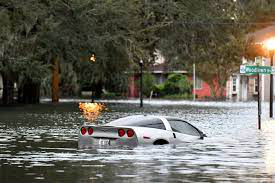

In [35]:
# pipeline 확인
Image.open(inhovation_Dataset(Dataset_path,'train', transform = None).all_data[0])

2. albumentation을 이용해 data augmentation을 적용하기
> 이 경우에도 마찬가지로 먼저 image를 resize한 뒤에 normalize를 적용합니다.

In [36]:
import albumentations
import albumentations.pytorch

albumentations_resize = albumentations.Compose([
                                                
    albumentations.Resize(128, 128), 
    albumentations.pytorch.transforms.ToTensorV2()
    
])

resize_train=inhovation_Dataset(Dataset_path, 'train', transform=albumentations_resize)
resize_test=inhovation_Dataset(Dataset_path, 'test', transform=albumentations_resize)

데이터 클래스를 거쳐 나온 이미지 데이터는 텐서 형태입니다. 따라서 시각화를 위해 [height, width, channels] 형태로 배열을 다시 바꿔줘야합니다.

In [37]:
def tensor_img(img):    
    img = img.permute(1,2,0)
    plt.imshow(img)

In [38]:
resize_train[488][0].numpy().shape

(3, 128, 128)

In [39]:
resize_train[488][0].permute(1,2,0).shape

torch.Size([128, 128, 3])

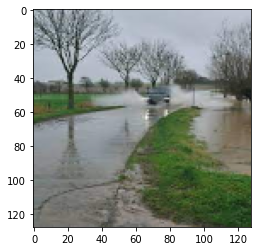

In [40]:
# 128 x 128 변환 성공
tensor_img(resize_train[488][0])

3. albumentation으로 data augmentation해주기
> 훨씬 더 **빠르다**   
> 훨씬 더 **다양하다**   
> **편리하다**   
> 특히 객체 탐지 모델의 bounding box까지도 같이 처리가 가능하다



In [41]:
import albumentations
import albumentations.pytorch
from torchvision import transforms # 이미지 데이터 transform
from torch.utils.data import DataLoader # 이미지 데이터 로더

albumentations_train = albumentations.Compose([
                                                
    albumentations.Resize(128, 128),   
    albumentations.OneOf([
                          albumentations.HorizontalFlip(p=0.8), # p확률로 이미지 좌우 반전
                          albumentations.RandomRotate90(p=0.8), # p확률로 90도 회전
                          albumentations.VerticalFlip(p=0.8) # p확률로 이미지 상하 반전
    ], p=1),

    albumentations.OneOf([
                          albumentations.MotionBlur(p=0.8), # p확률로 이미지를 흐리게(?) 만들어 줌
                          albumentations.OpticalDistortion(p=0.8), # p확률로 이미지 왜곡
                          albumentations.GaussNoise(p=0.8) # 임의의 noise를 삽입          
    ], p=1),
    # albumentations.Normalize(mean = resize_train_mean, std = resize_train_std),
    albumentations.pytorch.ToTensorV2()
    
])

albumentations_test = albumentations.Compose([
                                                
    albumentations.Resize(128, 128),
    albumentations.pytorch.ToTensorV2()
    
])


trainset=inhovation_Dataset(Dataset_path, 'train', transform=albumentations_train)
testset=inhovation_Dataset(Dataset_path, 'test', transform=albumentations_test)

train_loader = torch.utils.data.DataLoader(trainset, batch_size=1,
                                          shuffle=True, num_workers=0)

test_loader = torch.utils.data.DataLoader(testset, batch_size=1,
                                         shuffle=False, num_workers=0)

albumentations이 왜인지 tensor형태의 데이터를 normalize해주지 못함

In [42]:
trainset[222][0]

tensor([[[152, 148, 145,  ..., 126, 162, 125],
         [136, 123, 137,  ..., 133, 144, 135],
         [151, 128, 138,  ..., 130, 119, 110],
         ...,
         [ 43,  56,  60,  ...,  73,  76,  70],
         [ 57,  67,  52,  ...,  83,  80,  67],
         [ 62,  59,  58,  ..., 102,  85,  80]],

        [[132, 122, 137,  ..., 105, 151,  95],
         [118, 112, 109,  ..., 102, 126, 109],
         [111,  71, 118,  ..., 115, 106, 106],
         ...,
         [ 60,  46,  53,  ...,  96,  81,  67],
         [ 53,  78,  50,  ...,  85,  84,  82],
         [ 48,  69,  62,  ..., 105,  80,  72]],

        [[117, 113, 136,  ...,  89, 110,  88],
         [ 94, 109, 107,  ...,  87, 111,  84],
         [ 95,  88,  94,  ..., 100,  93,  88],
         ...,
         [ 24,  31,  39,  ...,  72,  83,  59],
         [ 46,  45,  52,  ...,  90,  81,  58],
         [ 43,  61,  49,  ..., 119,  79,  71]]], dtype=torch.uint8)

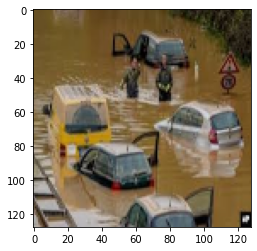

In [43]:
plt.imshow(resize_train[600][0].permute(1,2,0))

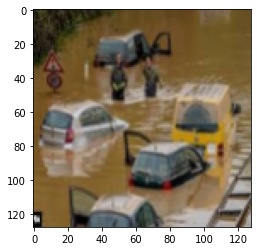

In [44]:
tensor_img(trainset[600][0])